**TODO**
1. Add provenance information, export to json? Using the prov python package maybe.
or maybe provenance info in form of comments is sufficent?
2.  Evaluation and testing.
3. Comparison with JavaSOM for the same vis? - see the note in evaluation

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Provenance Information Generation

In [5]:
from prov.model import ProvDocument, PROV_TYPE, Namespace
from datetime import datetime

doc = ProvDocument()

ex = Namespace(
    "ex", "http://example/"
)

user = doc.agent(ex["user"], {PROV_TYPE: 'prov:Person', 'ex:name': "Terezia"})

repo_entity = doc.entity(ex["repository"], 
    {
        PROV_TYPE: "prov:Repository",
        "prov:label": "GitHub Repository",
        "prov:value": "https://github.com/teriolx/PySOMVis-LabelSOM",
        ex["description"]: "This is a fork of the repository implementing the PySOMVis tool. This version adds a new type of visualization - the LabelSOM. ",
    }
)

dataset1 = doc.entity(ex["dataset"], 
    {
        PROV_TYPE: "prov:Dataset",
        "prov:label": "10 clusters",
        "prov:value": "/datasets/10clusters",
    })

dataset2 = doc.entity(ex["dataset"], 
    {
        PROV_TYPE: "prov:Dataset",
        "prov:label": "chainlink",
        "prov:value": "/datasets/chainlink",
    })

def generate_plot_prov_info(func):
    '''
    Decorator that generates the provenance info.
    '''
    def wrapper(*args, **kwargs):
        start = datetime.now().isoformat()
        func(*args, **kwargs)

        parameters = {ex[identifier]:value for identifier, value in kwargs.items()}
        plot_activity = doc.activity(ex["plotCreation"], start, datetime.now().isoformat(), parameters)

        agent = doc.agent("prov:SoftwareAgent")

        doc.wasAssociatedWith(plot_activity, agent)

        plot_entity = doc.entity(ex["SOMPlot"])

        doc.wasGeneratedBy(plot_entity, plot_activity)
        doc.used(plot_activity, repo_entity, None, {"prov:role": "Code Repository"})
        doc.wasAttributedTo(plot_entity, user)

        doc.serialize(f"SOM_plot_{start}.ttl", format="rdf", rdf_format="ttl")
    
    return wrapper

# LabelSOM
----
Authors:
Johannes Le (11918056) and Terezia Olsiakova (12331438)

**Code repository**: [PySOMVis-LabelSOM](https://github.com/teriolx/PySOMVis-LabelSOM)

----

LabelSOM (class `LabelSOM`): 
print the names of the n attributes 
- A) per unit (method `display_per_unit()`)
- B) per cluster (method `display_per_cluster()`) as defined by one of the clustering techniques available 

that show 

1) the lowest variance (parameter setting `var_coeff=1, mean_coeff=0`)
2) the highest mean values within a specific unit or cluster (parameter setting `var_coeff=0, mean_coeff=1`)
3) a weighted combination of these (set the `var_coeff, mean_coeff` parameters as desired) 

as text on the map units / clusters.

Parameters that should be adjustable by the user include:
- the maximum number of labels to be displayed (`n_labels`)
- thresholds for the three selection types (`selection_threshold`)
- relative weights for the combined selection of labels (`var_coeff, mean_coeff`)
- the amount of detail being provided (labels-only or labels + values)
    - for labels-only set `display_values=False` (default)
    - for labels + values set `display_values=True`
- font size selection depending on the label weights (default `scale_text=True`).


In [3]:
class LabelSOM():
    def __init__(self, input_matrix, weight_matrix, attr_names=None):
        '''
        Class for the LabelSOM visualization. Offers plotting the labels
        of the relevant features per each unit of the SOM, alternatively
        per cluster of clustered SOM units. 

         
        Attributes:
            --- set at init ---
            input_matrix (n_instances, n_features): the matrix with input instances set at init 
            weight_matrix (x_dim, y_dim, n_features): the SOM weight matrix set at init
            
            ---   derived   ---
            x_dim: the first dimension of the SOM
            y_dim: the second dimension of the SOM
            n_instances: number of input instances
            n_features: number of input (and weight) matrix features
            input_matrix_scaled: zero-mean scaled input matrix 
            weight_matrix_scaled: zero-mean scaled weight matrix 
            attr_names (n_features): list of input feature names 

        Methods:
            --- public  ---
            display_per_unit: show the LabelSOM per unit of the SOM
            display_per_cluster: show the LabelSOM per clustered units
            
            --- private ---
            _extract_bmu: assign each input instance to its BMU of the SOM            
            _extract_attributes: 
            _plot_texts: handles the plotting of the resulting LabelSOM
        '''
        self.input_matrix = input_matrix
        self.weight_matrix = weight_matrix
        x_dim, y_dim, n_weight_features = weight_matrix.shape
        n_instances, n_features = input_matrix.shape

        if n_weight_features != n_features:
            raise ValueError("The weight matrix and input matrix have different feature dimensions.")

        self.x_dim = x_dim
        self.y_dim = y_dim
        self.n_instances = n_instances
        self.n_features = n_features

        scaler = StandardScaler()
        self.input_matrix_scaled = scaler.fit_transform(input_matrix)
        self.weight_matrix_scaled = scaler.fit_transform(weight_matrix.reshape((self.x_dim * self.y_dim, self.n_features)))
        
        self.attr_names = attr_names
        if attr_names is None:
            self.attr_names = ["attr_" + str(i + 1) for i in range(0, n_features)] 
        self.attr_names = np.array(self.attr_names)
    
    @generate_plot_prov_info
    def display_per_unit(self, n_labels, selection_threshold=0,
                         var_coeff=0, mean_coeff=1, 
                         scale_text=True, display_values=False):
        '''
        Displays the labels per unit of the SOM according to the user's settings.

        Attributes:
            n_labels: maximum number of desired labels to display (per unit)
            selection_threshold: only consider labels with calculated values above this one
            var_coeff: selection method configuration (see also _extract_attributes())
            mean_coeff: selection method configuration (see also _extract_attributes())
            scale_text: whether label text should be scaled according to its value
            display_values: whether values should be displayed together with the label
        
        Return:
            nothing (the plot is shown)
        '''
        # assign each input instance to its BMU
        bmu_map = self._extract_bmu()

        # prepare the labels for plotting
        labels_dict = {}
        for i, row in enumerate(bmu_map):
            for j, bmus in enumerate(row):
                if not bmus:
                    # empty unit since no input instances have it as their BMU
                    continue
                labels_dict[(i, j)] = self._extract_attributes(bmus, n_labels,
                                                                         var_coeff, mean_coeff, 
                                                                         selection_threshold)
        
        self._plot_texts(labels_dict, scale_text, display_values)
    
    @generate_plot_prov_info
    def display_per_cluster(self, n_clusters, n_labels, selection_threshold=0,
                            var_coeff=0, mean_coeff=1, 
                            scale_text=True, display_values=False):
        '''
        Displays the labels per cluster of the SOM according to the user's settings.

        Attributes:
            n_clusters: number of desired clusters of the SOM 
            n_labels: maximum number of desired labels to display (per unit)
            selection_threshold: only consider labels with calculated values above this one
            var_coeff: selection method configuration (see also _extract_attributes())
            mean_coeff: selection method configuration (see also _extract_attributes())
            scale_text: whether label text should be scaled according to its value
            display_values: whether values should be displayed together with the label
        
        Return:
            nothing (the plot is shown)
        '''
        kmeans = KMeans(n_clusters=n_clusters).fit(self.weight_matrix_scaled)
        clusters = kmeans.labels_.reshape((self.x_dim, self.y_dim))
        
        # assign each cluster its center unit by choosing
        # the first unit that belongs to this cluster when
        # reading the SOM left to right and top to bottom
        center_units = {}
        for i, row in enumerate(clusters):
            for j, c_idx in enumerate(row):
                if center_units.get(c_idx) is None:
                    center_units[c_idx] = (i, j)

        # assign each input instance into its BMU and
        # cluster the units 
        clusters_map = {i: [] for i in range(n_clusters)}
        bmu_map = self._extract_bmu()
        for i, row in enumerate(bmu_map):
            for j, bmus in enumerate(row):
                cluster_idx = clusters[i][j]
                clusters_map[cluster_idx] += bmus

        # extract the attributes to be displayed per cluster
        # and prepare them for plotting
        labels_dict = {}
        for idx, (i, j) in center_units.items():
            if not clusters_map[idx]:
                continue
            labels_dict[(i, j)] = self._extract_attributes(clusters_map[idx], n_labels, 
                                                                   var_coeff, mean_coeff, selection_threshold)
        
        self._plot_texts(labels_dict, scale_text, display_values, clusters)

    def _extract_bmu(self):
        '''
        Maps every input vector from the input to its best-matching unit
        in the trained SOM. The BMU is the one with the smallest Euclidean 
        distance to the input instance.

        Attributes:
            input_matrix (n_entries, n_features): contains the input data points   
            weight_matrix (x_dim, y_dim, n_features): contains the learned weights

        Returns:
            bmu_map (x_dim, y_dim): 2D list, where each cell represents a unit of SOM
                                    and contains the list of indices (range of n_entries)
                                    for which this unit is the BMU
        '''
        bmu_map = [[[] for _ in range(self.y_dim)] for _ in range(self.x_dim)]

        for i in range(self.n_instances):
            row = self.input_matrix[i]
            bmu_idx = np.linalg.norm(self.weight_matrix - row, axis=-1).argmin()
            unit_x, unit_y = np.unravel_index(bmu_idx, (self.x_dim, self.y_dim))
            bmu_map[unit_x][unit_y].append(i)

        return bmu_map

    def _extract_attributes(self, unit_bmus, n_labels, 
                            var_coeff, mean_coeff, selection_threshold):
        '''
        Extract the n attributes of the unit based on the
        desired setting.

        Attributes:
            unit_bmus: list of the indices of instances for which this unit is BMU
            n_labels: maximum number of desired labels to extract
            var_coeff: controls the selection method (see note below)
            mean_coeff: controls the selection method (see note below)
            selection_threshold: only attributes with values above this value are considered

        Returns:
            sorted list of attributes represented as tuples of attribute names and calculated scores

        Note on the selection method (var_coeff, mean_coeff):
            (1, 0) -> select lowest variance
            (0, 1) -> select highest mean
            (x, y) -> combined selection with the given weights, sorted ascendingly
        '''
        instances = [self.input_matrix_scaled[i] for i in unit_bmus]
        data = np.stack(instances)

        vars = np.var(data, axis=0)
        means = np.mean(data, axis=0)

        values = var_coeff * vars + mean_coeff * means
        threshold_mask = values > selection_threshold
        sorting_mask = np.argsort(values[threshold_mask])

        if var_coeff == 0 and mean_coeff == 1:
            # highest variance -> inverse order
            sorting_mask = sorting_mask[::-1]

        sorted_names = self.attr_names[threshold_mask][sorting_mask][:n_labels]
        sorted_values = values[threshold_mask][sorting_mask][:n_labels]
        
        return list(zip(sorted_names, sorted_values))
        
    def _plot_texts(self, labels_dict, scale_text, display_values, clusters=None):
        '''
        Helper method that plots the labels in the corresponding unit
        of the SOM.

        Attributes:
            labels_dict: created in display_per_unit(), contains information 
                         on which cell should contain which labels
            scale_text: user setting for scaling text (see also display_per_unit())
            display_values: user setting for displaying values (see also display_per_unit())

        Return:
            nothing (the plot is shown)
        '''
        fig, ax = plt.subplots(figsize=(1.5 * self.y_dim, 1.5* self.x_dim))

        # create a grid that represents the units of the SOM
        ax.set_xticks(range(self.y_dim + 1))
        ax.set_yticks(range(self.x_dim + 1))
        ax.grid(linewidth=1, linestyle="-")
        plt.gca().invert_yaxis()

        if clusters is not None:
            # color the units based on clusters
            plt.imshow(clusters, cmap="plasma", origin="upper", 
                       extent=(0, self.y_dim, self.x_dim, 0))
        
        # plot the labels in the desired unit (grid cell) of the SOM
        for coords, labels in labels_dict.items():
            y, x = coords
            seg_height = 1 / (len(labels) + 1)
            for idx, (label, weight) in enumerate(labels):
                fontsize = 9 if not display_values else 4
                if scale_text:
                    fontsize += 4 * weight
                text = label
                if display_values:
                    text += f" ({weight:.2f})"
                ax.text(x + 0.5, y + (idx + 1) * seg_height, text,
                         ha="center", va="center", fontsize=fontsize)

        plt.show() 

## Evaluation
**Assignment requirements**:
1. Pick the Chainlink Data Set (/datasets/chainlink) and the 10-Clusters dataset (/datasets/10clusters).
2. Train a 10x10 (small) and a 100x60 (large) SOM. Make sure that the SOMs are properly trained, i.e. that the structures to be expected in the SOM become clearly visible by identifying suitable parameters for the initial neighborhood radius and initial learning rate.
3. Show the visualizations, providing examples with different parameter settings and comparisons that allow a validation of the correctness of the implementation. Specifically, test a few extreme values for the parameter settings.
-------
Not planned: 

4. Where an identical visualization exists in the JÁVA SOM toolbox, read a SOM pre-trained
with the JAVA SOM Toolbox (import functions are provided in the notebook) and compare
your visualization with the one produced by the Java SOMToolbox

-> I don't think the LabelSOM exists in this PySOMVis package (checked the visualization folder) and I could not dowload the Java SOM executable, it kept failing to download xD There are some examples in the slides (s. 189-191) using the animals dataset, but it is hard to tell what the training was, so we could probably not get a fair comparison. 

### 10clusters - Small SOM (10 x 10)

In [4]:
from SOMToolBox_Parse import SOMToolBox_Parse
idata   = SOMToolBox_Parse("datasets/10clusters/10clusters.vec").read_weight_file()
classes = SOMToolBox_Parse("datasets/10clusters/10clusters.cls").read_weight_file()

In [5]:
som = MiniSom(10, 10, idata['vec_dim'])
som.train(idata['arr'], 10000)

weights = som.get_weights()

In [6]:
label_som_small = LabelSOM(idata["arr"], weights)

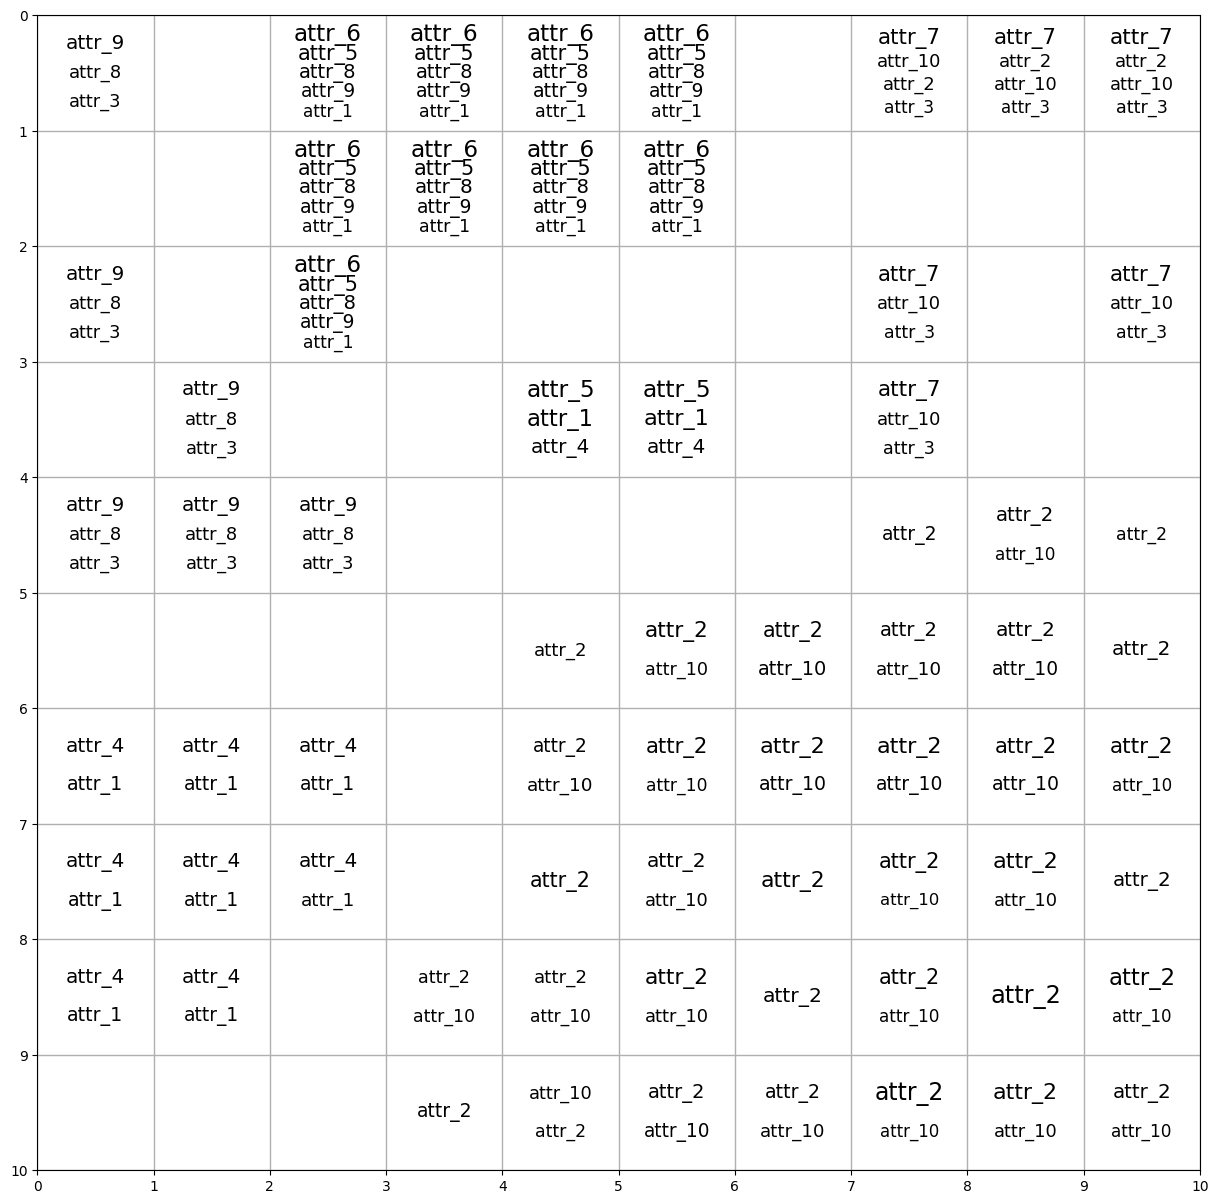

In [8]:
label_som_small.display_per_unit(n_labels=5, selection_threshold=0.7,
                         var_coeff=0, mean_coeff=1, 
                         scale_text=True, display_values=False)

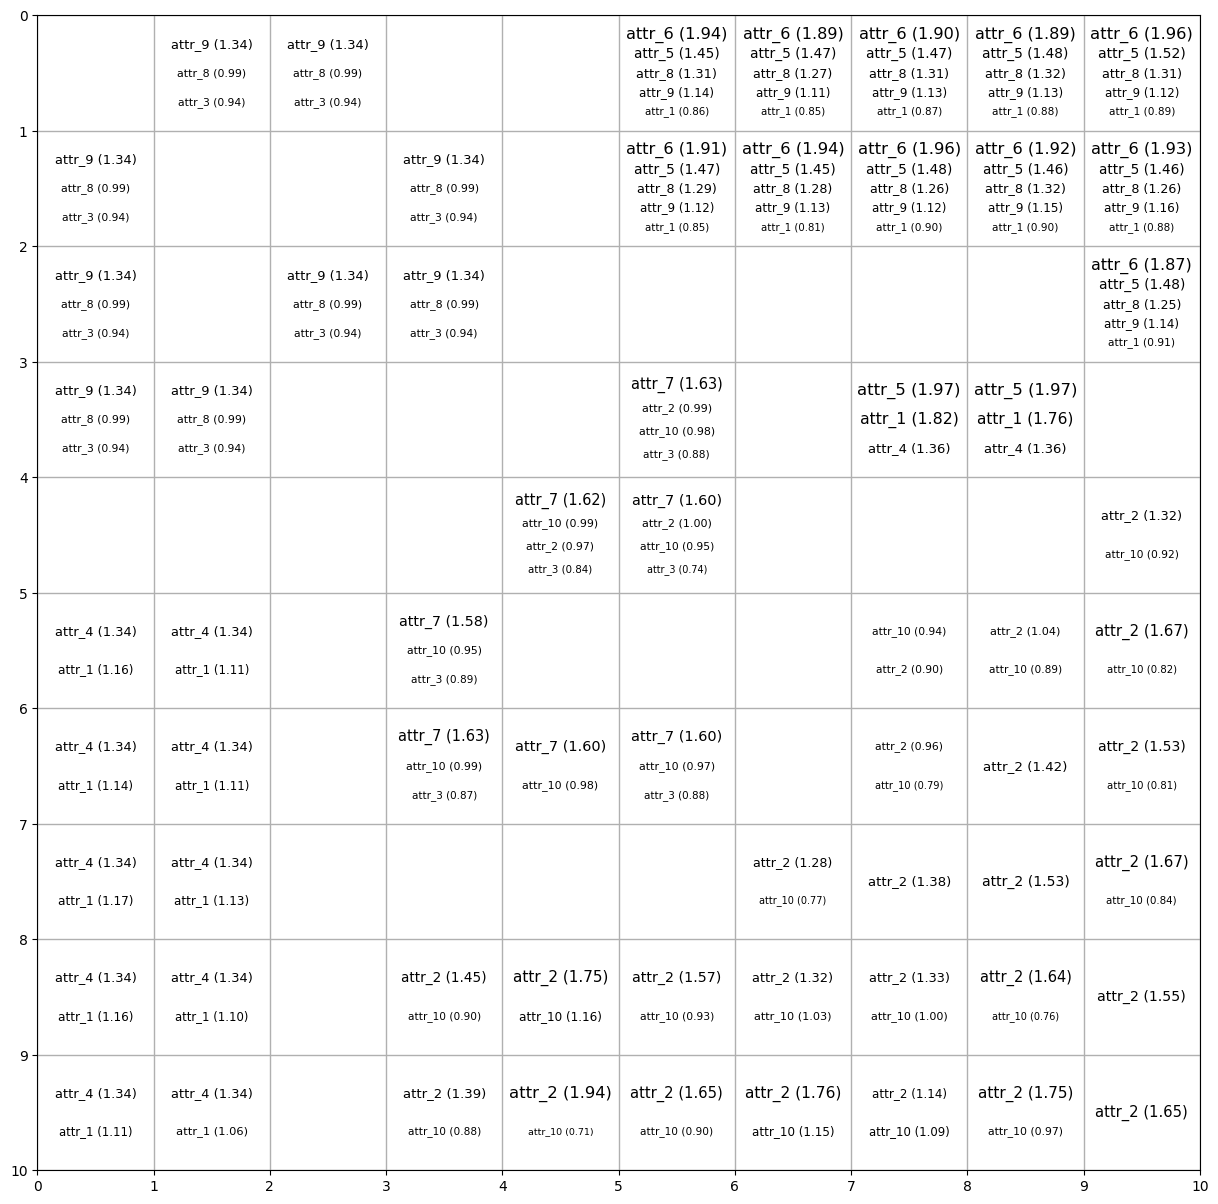

In [7]:
label_som_small.display_per_unit(5, selection_threshold=0.7, display_values=True)

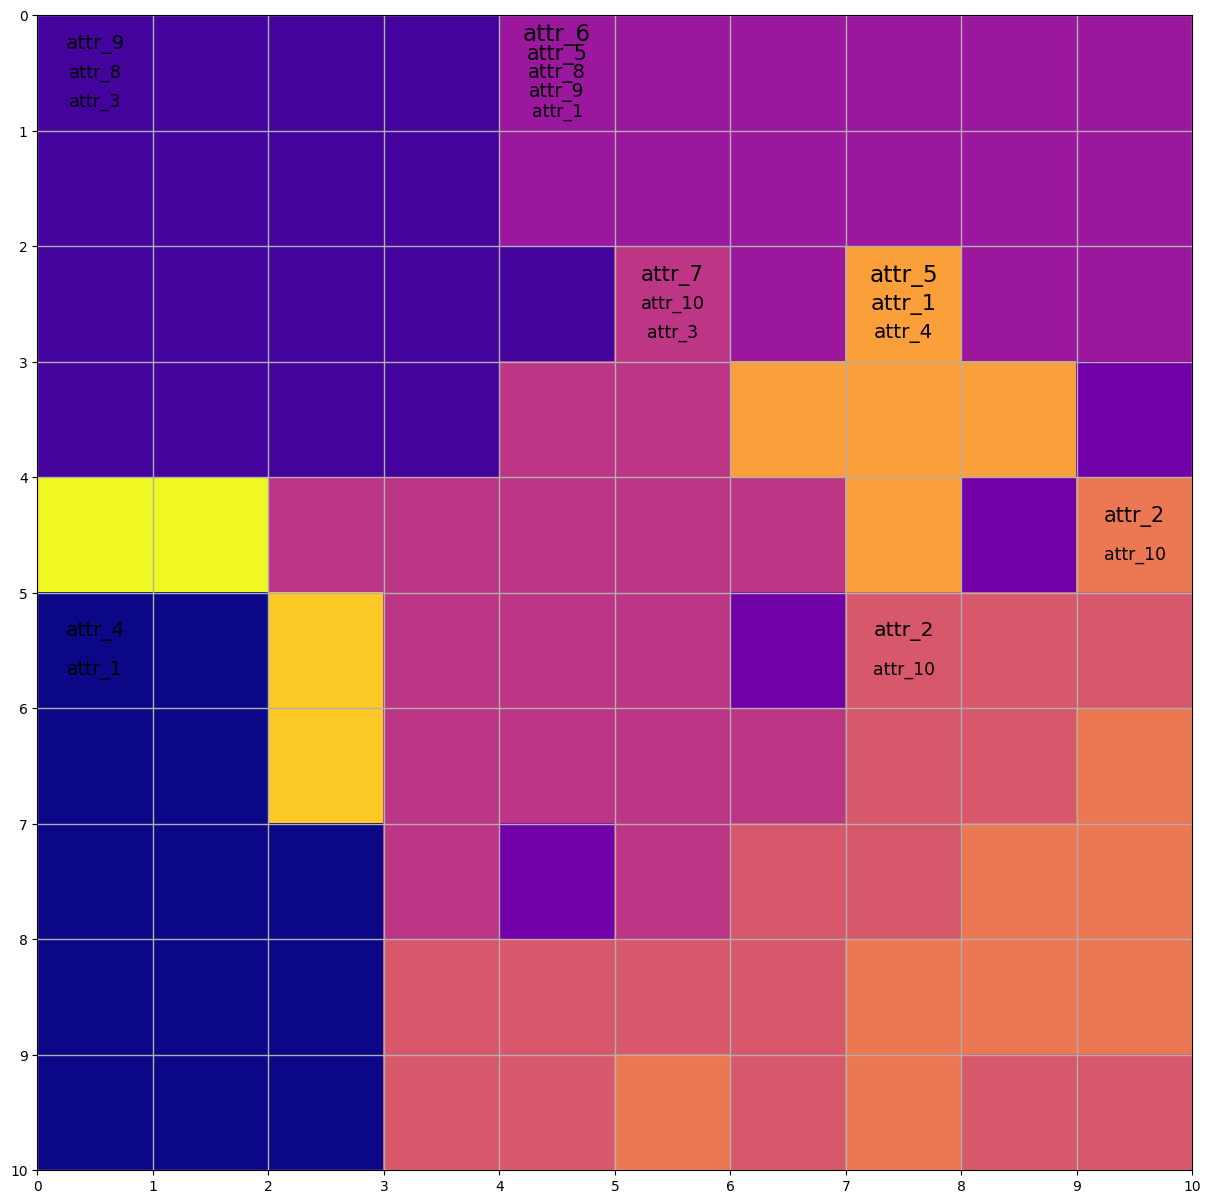

In [8]:
label_som_small.display_per_cluster(10, 5, selection_threshold=0.7)

### 10clusters - Big SOM (100x60)

In [9]:
som = MiniSom(100, 60, idata['vec_dim'])
som.train(idata['arr'], 10000)

weights = som.get_weights()

In [ ]:
label_som_big = LabelSOM(idata["arr"], weights)

In [11]:
label_som_big.display_per_unit(5, selection_threshold=0.7)

In [12]:
label_som_big.display_per_unit(5, selection_threshold=0.7, display_values=True)

In [13]:
label_som_big.display_per_cluster(10, 5, selection_threshold=0.7)

### Plotting the trained SOM using other visualizations

Just for checking while testing, probably not needed in the final version.  

In [ ]:
w, h, d = weights.shape

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
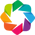

Launching server at http://localhost:43793


ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : key "line_alpha" value "alpha" [renderer: GlyphRenderer(id='1073', ...)]


In [15]:
# Visualization by PySOMVis
from pysomvis import PySOMVis

vis = PySOMVis(weights=weights.reshape(w*h, d), m=w, n=h,
                dimension=d, input_data=idata['arr'],
                classes=classes['arr'][:,1])
vis._onbigscreen()